In [1]:
import pandas as pd
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

tableau10 = [(78, 121, 167), (242, 142, 43), (225, 87, 89), 
             (118, 183, 178), (89, 161, 79), (237, 201, 72), 
             (176, 122, 161), (225, 157, 167), (156, 117, 95), 
             (186, 176, 172)]

for i in range(len(tableau10)):    
    r, g, b = tableau10[i]    
    tableau10[i] = (r / 255., g / 255., b / 255.)
    
%matplotlib inline

# Import Data
Import GISTIC and then import SNV & InDels

In [2]:
input_gistic = 'data/gistic/all_thresholded.by_genes_whitelisted.tsv'
gistic = pd.read_csv(input_gistic, sep = '\t')

In [3]:
target_categories = ['Potential TARGET Actionability', 'Investigate TARGET Actionability', 'High Priority']

allFiles = glob.glob('data/somatic_phial_output/*/*detailed.txt')
df = pd.DataFrame()
list_ = []
var_count = 0
sample_count = 0
samples = []

for file_ in allFiles:
    tissue = file_.split('/')[2]
    df_ = pd.read_csv(file_, index_col = None, sep = '\t', comment = '#', low_memory = False)    
    samples += df_['Tumor_Sample_Barcode'].unique().tolist()
    var_count += len(df_)
    sample_count += len(df_['Tumor_Sample_Barcode'].unique().tolist())
    
    df_ = df_[df_['Score_bin'].isin(target_categories)]
    df_['CODE'] = tissue
    list_.append(df_)
df_snv = pd.concat(list_, ignore_index = True)
df_snv['Tumor_Sample_Barcode_short'] = df_snv['Tumor_Sample_Barcode'].str[:-16]

In [4]:
targetv142 = pd.read_csv('reference/target/TARGET_db_v1.4.2_05312017.txt', sep = '\t', comment = '#')

df_snv = df_snv[df_snv['Gene'].isin(targetv142['Gene'])]

# Gather intersection of samples

In [5]:
df_snv_samples = pd.DataFrame([], columns = ['SNV sample full', 'Individual', 'CODE'])
df_snv_samples['SNV sample full'] = samples
df_snv_samples['Individual'] = df_snv_samples['SNV sample full'].str[:-16]

df_cnv_samples = pd.DataFrame([], columns = ['CNV sample full', 'Individual'])
df_cnv_samples['CNV sample full'] = gistic.iloc[:,3:].columns.tolist()
df_cnv_samples['Individual'] = gistic.iloc[:,3:].rename(columns = lambda x: str(x)[:-16]).columns.tolist()

In [7]:
df_samples = pd.merge(df_snv_samples, df_cnv_samples, on = ['Individual'])
df_samples = df_samples.loc[:,['CODE', 'Individual', 'SNV sample full', 'CNV sample full']]

# Map sample names with sample names from SNVs and CNVs and also Tissue Type.
for sample_ in df_samples['SNV sample full']:
    if sample_ in df_snv['Tumor_Sample_Barcode'].unique().tolist():
        index_snv = df_snv[df_snv['Tumor_Sample_Barcode'] == sample_].index[0]
        code = df_snv.loc[index_snv, 'CODE']
    
        index_ = df_samples[df_samples['SNV sample full'] == sample_].index[0]
        df_samples.loc[index_, 'CODE'] = code
    else:
        index_ = df_samples[df_samples['SNV sample full'] == sample_].index[0]
        df_samples.loc[index_, 'CODE'] = 'Unknown'
        
# Check that mappings match
study_mappings = pd.read_csv('reference/summary/TCGA_Study_Lookup.txt', sep = '\t', comment = '#')
study_mappings.loc[779, 'TSS Code'] = 'NA' # Silly Python :) 

code_count = 0
for index_ in df_samples.index.tolist():
    tss_code = df_samples.loc[index_, 'Individual'][5:-5]
    sample_code = study_mappings[study_mappings['TSS Code'] == tss_code]['Study Abbreviation']
    sample_code = sample_code.get_values()[0]
            
    if (df_samples.loc[index_, 'CODE'] == 'Unknown'):
        df_samples.loc[index_, 'CODE'] = sample_code
        code_count += 1

print 'We observe', str(len(df_samples)), 'samples that have both SNV calls and CNV calls.'

We observe 8775 samples that have both SNV calls and CNV calls.


In [8]:
# Independent Check
snv_samples = [sample_[:-16] for sample_ in samples]
cnv_samples = gistic.iloc[:,3:].rename(columns = lambda x: str(x)[:-16]).columns.tolist()
intersection_samples = list(set(snv_samples) & set(cnv_samples))

print 'Number of SNV samples:', str(len(snv_samples))
print 'Number of CNV sampes:', str(len(cnv_samples))
print 'Intersection samples:', str(len(intersection_samples))

Number of SNV samples: 9079
Number of CNV sampes: 10713
Intersection samples: 8775


# Create Integrated DataFrame

In [9]:
# Subset df_SNV and df_cnv for intersection samples
df_snv_ = df_snv[df_snv['Tumor_Sample_Barcode'].isin(df_samples['SNV sample full'])]

df_cnv_ = pd.concat([gistic.iloc[:,:3], gistic.loc[:, df_samples['CNV sample full'].tolist()]], axis = 1)
df_cnv_ = df_cnv_[df_cnv_['Gene Symbol'].isin(targetv142['Gene'])]
df_cnv_ = df_cnv_.replace([-1,1], value = [0,0])

# Amp genes and del genes
amp_genes = targetv142[targetv142['Types_of_recurrent_alterations'].str.lower().str.contains('amplification')]['Gene'].tolist()
del_genes = targetv142[targetv142['Types_of_recurrent_alterations'].str.lower().str.contains('deletion|biallelic inactivation')]['Gene'].tolist()

# Add CNV values
def create_cnv_df(df_input, gene_list):
    df = df_input[df_input['Gene Symbol'].isin(gene_list)]
    df.index = df.loc[:,'Gene Symbol'].tolist()
    df = df.iloc[:,3:]
    return(df)

# Putatively Actionable CNV alterations
df_cnv_amp = create_cnv_df(df_cnv_, amp_genes)
df_cnv_del = create_cnv_df(df_cnv_, del_genes)

df_cnv_amp[df_cnv_amp < 0] = 0
df_cnv_del[df_cnv_del > 0] = 0
df_cnv_del = df_cnv_del.abs()

df_PA_cnv = pd.concat([df_cnv_amp, df_cnv_del])

df_cnv_hits = df_cnv_.copy(deep = True)
df_cnv_hits = df_cnv_hits.replace(2, value = 1)
df_cnv_hits = df_cnv_hits.replace(-2, value = 1)

In [10]:
df = df_samples.copy(deep = True)
df['# SNVs PA'] = 0
df['# SNVs BR'] = 0
df['# CNVs PA'] = 0
df['# CNVs BR'] = 0
df['# SNVs'] = 0
df['# CNVs'] = 0
df['# PA'] = 0
df['# BR'] = 0

for index_ in df.index.tolist():
    sample_ = df.loc[index_, 'SNV sample full']
    tmp_snv = df_snv_[df_snv_['Tumor_Sample_Barcode'] == sample_]
    df.loc[index_, '# SNVs'] = len(tmp_snv)
    if ('Investigate TARGET Actionability' in tmp_snv['Score_bin'].tolist()):
        df.loc[index_, '# SNVs PA'] = tmp_snv['Score_bin'].value_counts()['Investigate TARGET Actionability']
    if ('High Priority' in tmp_snv['Score_bin'].tolist()):
        df.loc[index_, '# SNVs BR'] = tmp_snv['Score_bin'].value_counts()['High Priority']
    
    sample_ = df.loc[index_, 'CNV sample full']
    df.loc[index_, '# CNVs PA'] = df_PA_cnv.sum()[sample_]/2
    df.loc[index_, '# CNVs'] = df_cnv_hits.iloc[:,3:].sum()[sample_]
    
df['# CNVs BR'] = df['# CNVs'] - df['# CNVs PA']
df['# PA'] = df['# SNVs PA'] + df['# CNVs PA']
df['# BR'] = df['# SNVs BR'] + df['# CNVs BR']

# Summary

In [11]:
print 'A total of', str(len(intersection_samples)), 'samples had data for SNVs, InDels, and CNVs.'

A total of 8775 samples had data for SNVs, InDels, and CNVs.


In [12]:
columns_ = ['CODE', '# Samples', '# Samples w/ PA SNV only', '# Samples w/ PA CNV only', 
            '# Samples w/ PA SNV and CNV', '# Samples w/ PA',
           '% Samples w/ PA SNV only', '% Samples w/ PA CNV only', '% Samples w/ PA SNV and CNV',
           '% Samples w/ PA']
codes = df['CODE'].unique().tolist()

df['SNV PA only'] = 0
df['CNV PA only'] = 0
df['Both SNV CNV PA'] = 0
snvs_index = df[(df['# SNVs PA'] > 0) & (df['# CNVs PA'] == 0)].index.tolist()
cnvs_index = df[(df['# SNVs PA'] == 0) & (df['# CNVs PA'] > 0)].index.tolist()
both_index = df[(df['# SNVs PA'] > 0) & (df['# CNVs PA'] > 0)].index.tolist()

df.loc[snvs_index, 'SNV PA only'] = 1
df.loc[cnvs_index, 'CNV PA only'] = 1
df.loc[both_index, 'Both SNV CNV PA'] = 1

df_summary = pd.DataFrame([], columns = columns_, index = range(0, len(codes)))
df_summary['CODE'] = codes
for code_ in codes:
    index_ = df_summary[df_summary['CODE'] == code_].index.tolist()[0]
    df_tmp_ = df[df['CODE'] == code_]
    
    df_summary.loc[index_, '# Samples'] = len(df_tmp_)
    df_summary.loc[index_, '# Samples w/ PA SNV only'] = df_tmp_['SNV PA only'].sum()
    df_summary.loc[index_, '# Samples w/ PA CNV only'] = df_tmp_['CNV PA only'].sum()
    df_summary.loc[index_, '# Samples w/ PA SNV and CNV'] = df_tmp_['Both SNV CNV PA'].sum()
    
df_summary['# Samples w/ PA'] = df_summary['# Samples w/ PA SNV only'] + df_summary['# Samples w/ PA CNV only']
df_summary['# Samples w/ PA'] += df_summary['# Samples w/ PA SNV and CNV']
df_summary['% Samples w/ PA SNV only'] = (df_summary['# Samples w/ PA SNV only'] / df_summary['# Samples'])*100
df_summary['% Samples w/ PA CNV only'] = (df_summary['# Samples w/ PA CNV only'] / df_summary['# Samples'])*100
df_summary['% Samples w/ PA SNV and CNV'] = (df_summary['# Samples w/ PA SNV and CNV'] / df_summary['# Samples'])*100
df_summary['% Samples w/ PA'] = (df_summary['# Samples w/ PA'] / df_summary['# Samples'])*100

df_summary = df_summary.sort_values(by=['% Samples w/ PA'], ascending = False)
df_summary['label'] = df_summary['CODE'].astype(str) + ' (n=' + df_summary['# Samples'].astype(str) + ')'

In [13]:
df.to_csv('reference/summary/sample_summary.txt', sep = '\t', index = False)
df_summary.to_csv('reference/summary/tissue_summary.txt', sep = '\t', index = False)

# Create figure
We plot the percentage of patients with at least one putatively actionable alteration across tissue types, sorted by '% Samples w/ PA' (alterations). 

In [14]:
def to_percent(y, position):
    s = str(y)
    if plt.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

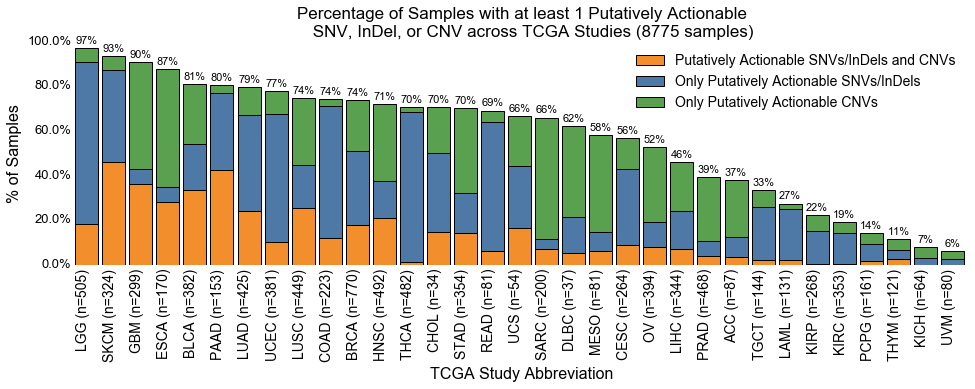

In [30]:
plt.figure(figsize=(16, 4))
plt.rc('font',family='Arial')

ax = plt.subplot()
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
plt.tick_params(axis="both", which="both", bottom="off", top="off",
    labelbottom="on", left="off", right="off", labelleft="on")  

ind = range(0, len(df_summary))

p1 = plt.bar(ind, df_summary['% Samples w/ PA SNV and CNV'], width = 0.85, color = tableau10[1],
            label = 'Putatively Actionable SNVs/InDels and CNVs')
p2 = plt.bar(ind, df_summary['% Samples w/ PA SNV only'], width = 0.85, color = tableau10[0],
            label = 'Only Putatively Actionable SNVs/InDels',
            bottom = df_summary['% Samples w/ PA SNV and CNV'])
p3 =  plt.bar(ind, df_summary['% Samples w/ PA CNV only'], width = 0.85, color = tableau10[4],
            label = 'Only Putatively Actionable CNVs',
            bottom = df_summary['% Samples w/ PA SNV and CNV'] + df_summary['% Samples w/ PA SNV only'])

formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
ax.yaxis.set_tick_params(labelsize=13)

xtick_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in p1]
ax.set_xticks(xtick_pos)
ax.set_xticklabels(df_summary['label'].tolist(), rotation = 90, size = 14, ha = 'right', fontname = 'Arial')

plt.xlabel('TCGA Study Abbreviation', fontsize = 16, fontname='Arial')
plt.ylabel('% of Samples', fontsize = 16, fontname='Arial')

title_ = 'Percentage of Samples with at least 1 Putatively Actionable\n \
    SNV, InDel, or CNV across TCGA Studies (8775 samples)'
plt.title(title_, fontsize = 17, fontname = 'Arial', y = 1.0)

for r1,r2,r3 in zip(p1, p2, p3):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    plt.text(r1.get_x()+r1.get_width()/2., h1+h2+h3 + 1, '%s'% (np.int(h1+h2+h3)) + '%', 
             ha = 'center', va='bottom', fontsize = 11, fontname = 'Arial')

plt.legend(fontsize = 14, frameon = False)
plt.xlim(0,33)
#plt.savefig('figures/tcga_phial_arial.pdf', format='pdf', bbox_inches = 'tight')
plt.show()

In [16]:
# Percent of samples with Putatively Actionable events
round(float(df_summary['# Samples w/ PA'].sum()) / float(8775), 3)

0.639